# LinkedIn Post Engagement Prediction — 3-Class Classification
## Implementation of Classification Plan

**Date:** February 2, 2026  
**Objective:** Predict LinkedIn post engagement performance using 3-class classification

---

## 🎯 Target Variable

**3-Class Engagement Classification:**
- **Class 0 — Below Average**
- **Class 1 — Average**
- **Class 2 — Above Average**

Prediction based on post structure, content features, and author context.

---

## Pipeline Overview

1. Load feature-engineered data
2. Define engagement_rate target variable
3. Create 3 classes (per-influencer thresholds recommended)
4. Remove data leakage features
5. Feature selection (reduce to 30-60 features)
6. Train/test split (GroupKFold by influencer)
7. Baseline model (Logistic Regression)
8. Production model (LightGBM/XGBoost/CatBoost)
9. Handle class imbalance
10. Evaluation (F1 Score, Confusion Matrix, ROC-AUC)
11. Feature importance + SHAP interpretation

---

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GroupKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
import lightgbm as lgb
try:
    import catboost as cb
    CATBOOST_AVAILABLE = True
except ImportError:
    CATBOOST_AVAILABLE = False
    print("⚠️  CatBoost not available. Install with: pip install catboost")

import shap
import joblib
import json
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Libraries imported")

✓ Libraries imported


c:\Users\rakib\Desktop\Work\Capstone\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load Data

In [2]:
# Load feature-engineered data
INPUT_FILE = '../data/feature_engineered_data.csv'
df = pd.read_csv(INPUT_FILE)

print(f"Dataset loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\nColumns: {list(df.columns[:10])}... (showing first 10)")
print(f"\nRequired columns check:")
required_cols = ['reactions', 'comments', 'followers', 'name']
for col in required_cols:
    if col in df.columns:
        print(f"  ✓ {col}")
    else:
        print(f"  ✗ {col} - MISSING!")

# Display basic info
print(f"\nData info:")
print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"  Missing values: {df.isnull().sum().sum()} total")
df.head(3)

Dataset loaded: 772 rows × 155 columns

Columns: ['name', 'content', 'reactions', 'comments', 'time_spent', 'location', 'followers', 'media_type', 'num_hashtags', 'url_count']... (showing first 10)

Required columns check:
  ✓ reactions
  ✓ comments
  ✓ followers
  ✓ name

Data info:
  Memory usage: 6.54 MB
  Missing values: 782 total


,name,content,reactions,comments,time_spent,location,followers,media_type,num_hashtags,url_count,...,reactions_vs_influencer_avg,comments_vs_influencer_avg,reactions_per_word,comments_per_word,reactions_per_sentiment,media_x_optimal_length,video_x_optimal_length,hook_x_power_score,sentiment_x_readability,feature_density
0,kevinswiber,I’m not famous. I’m not even popular. But I ha...,65.0,8.0,5,NaN,3690,post,0,0,...,1.0,1.0,1.857143,0.228571,125.920186,0,0,0,42.292727,0.085714
1,puneet-bhardwaj-849aa01,AI at the speed of light! While researching th...,34.0,2.0,3,NaN,2546,post,4,1,...,1.0,1.0,0.145923,0.008584,36.496350,0,0,0,45.541193,0.085837
2,jainnitin1983,I wanted to share that I’ve decided to move on...,34.0,5.0,1,NaN,3888,post,0,0,...,1.0,1.0,0.465753,0.068493,34.665579,0,0,0,56.477527,0.082192


## 3. Define Target Variable (Engagement Rate)

Removed 0 rows with invalid engagement_rate
Final dataset: 772 rows

ENGAGEMENT RATE STATISTICS
Mean: 0.034459
Median: 0.006441
Min: 0.000010
Max: 1.289308
Std: 0.094738


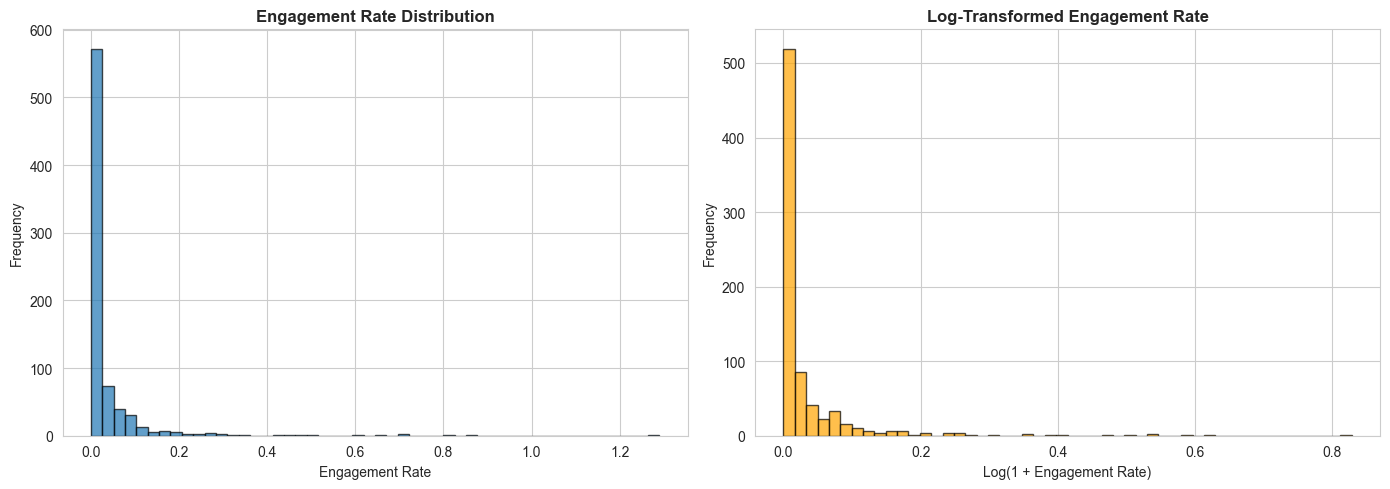

In [3]:
# Calculate engagement rate (normalized score)
# engagement_rate = (reactions + 2 × comments) / followers
df['engagement_rate'] = (df['reactions'] + 2 * df['comments']) / df['followers'].replace(0, 1)

# Handle infinite values (if followers = 0)
df['engagement_rate'] = df['engagement_rate'].replace([np.inf, -np.inf], np.nan)

# Remove rows with missing engagement_rate
initial_rows = len(df)
df = df.dropna(subset=['engagement_rate'])
print(f"Removed {initial_rows - len(df)} rows with invalid engagement_rate")
print(f"Final dataset: {len(df):,} rows")

# Display engagement_rate statistics
print("\n" + "="*80)
print("ENGAGEMENT RATE STATISTICS")
print("="*80)
print(f"Mean: {df['engagement_rate'].mean():.6f}")
print(f"Median: {df['engagement_rate'].median():.6f}")
print(f"Min: {df['engagement_rate'].min():.6f}")
print(f"Max: {df['engagement_rate'].max():.6f}")
print(f"Std: {df['engagement_rate'].std():.6f}")

# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(df['engagement_rate'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Engagement Rate')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Engagement Rate Distribution', fontweight='bold')

axes[1].hist(np.log1p(df['engagement_rate']), bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Log(1 + Engagement Rate)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Log-Transformed Engagement Rate', fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Create 3-Class Target Variable

CREATING 3-CLASS TARGET VARIABLE

Method: Per-Influencer Quantiles
  - Each influencer has different audience size
  - Removes follower bias
  - More realistic performance measure
  ⚠️  kevinswiber: Only 1 posts, using global quantiles
  ⚠️  puneet-bhardwaj-849aa01: Only 1 posts, using global quantiles
  ⚠️  jainnitin1983: Only 1 posts, using global quantiles
  ⚠️  zuzar-tinwalla-a4b9a423: Only 1 posts, using global quantiles
  ⚠️  kinlane: Only 2 posts, using global quantiles
  ⚠️  christianwestermann: Only 1 posts, using global quantiles
  ⚠️  rezashafii: Only 1 posts, using global quantiles
  ⚠️  samyuayyar: Only 1 posts, using global quantiles
  ⚠️  drbartpm: Only 1 posts, using global quantiles
  ⚠️  nadiacarlsten: Only 1 posts, using global quantiles
  ⚠️  coding-chats: Only 1 posts, using global quantiles
  ⚠️  progressivethinker: Only 1 posts, using global quantiles
  ⚠️  labyrinthlabs: Only 1 posts, using global quantiles
  ⚠️  roger-generative-ai: Only 1 posts, using global q

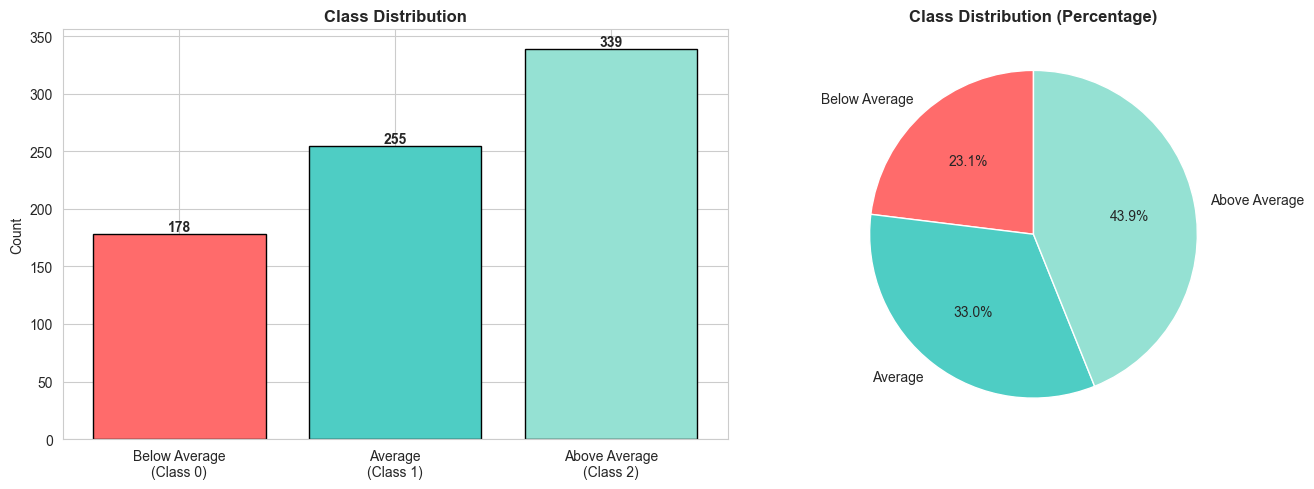


✓ Classes are reasonably balanced.


In [4]:
# Option: Per-Influencer Thresholds (Recommended)
# This removes follower bias and provides more realistic performance measure

print("="*80)
print("CREATING 3-CLASS TARGET VARIABLE")
print("="*80)

# Method: Per-Influencer Quantiles (Recommended)
print("\nMethod: Per-Influencer Quantiles")
print("  - Each influencer has different audience size")
print("  - Removes follower bias")
print("  - More realistic performance measure")

# Group by influencer and compute quantiles
df['engagement_class'] = np.nan

for influencer_name in df['name'].unique():
    mask = df['name'] == influencer_name
    influencer_data = df.loc[mask, 'engagement_rate']
    
    if len(influencer_data) >= 3:  # Need at least 3 posts for quantiles
        q1 = influencer_data.quantile(0.33)
        q2 = influencer_data.quantile(0.66)
        
        # Assign classes
        df.loc[mask & (df['engagement_rate'] < q1), 'engagement_class'] = 0  # Below Average
        df.loc[mask & (df['engagement_rate'] >= q1) & (df['engagement_rate'] < q2), 'engagement_class'] = 1  # Average
        df.loc[mask & (df['engagement_rate'] >= q2), 'engagement_class'] = 2  # Above Average
    else:
        # For influencers with < 3 posts, use global quantiles
        print(f"  ⚠️  {influencer_name}: Only {len(influencer_data)} posts, using global quantiles")

# Handle remaining NaN values with global quantiles
if df['engagement_class'].isna().any():
    global_q1 = df['engagement_rate'].quantile(0.33)
    global_q2 = df['engagement_rate'].quantile(0.66)
    
    mask_na = df['engagement_class'].isna()
    df.loc[mask_na & (df['engagement_rate'] < global_q1), 'engagement_class'] = 0
    df.loc[mask_na & (df['engagement_rate'] >= global_q1) & (df['engagement_rate'] < global_q2), 'engagement_class'] = 1
    df.loc[mask_na & (df['engagement_rate'] >= global_q2), 'engagement_class'] = 2

df['engagement_class'] = df['engagement_class'].astype(int)

# Display class distribution
print("\n" + "="*80)
print("CLASS DISTRIBUTION")
print("="*80)
class_counts = df['engagement_class'].value_counts().sort_index()
class_pct = df['engagement_class'].value_counts(normalize=True).sort_index() * 100

for cls in [0, 1, 2]:
    cls_name = ['Below Average', 'Average', 'Above Average'][cls]
    print(f"Class {cls} ({cls_name:15s}): {class_counts[cls]:5d} ({class_pct[cls]:5.2f}%)")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].bar(['Below Average\n(Class 0)', 'Average\n(Class 1)', 'Above Average\n(Class 2)'], 
            class_counts.values, color=['#ff6b6b', '#4ecdc4', '#95e1d3'], edgecolor='black')
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution', fontweight='bold')
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

axes[1].pie(class_counts.values, labels=['Below Average', 'Average', 'Above Average'], 
            autopct='%1.1f%%', colors=['#ff6b6b', '#4ecdc4', '#95e1d3'], startangle=90)
axes[1].set_title('Class Distribution (Percentage)', fontweight='bold')
plt.tight_layout()
plt.show()

# Check for class imbalance
is_balanced = (class_pct.min() > 20) and (class_pct.max() < 50)
if not is_balanced:
    print("\n⚠️  Class imbalance detected! Will use class weights or SMOTE.")
else:
    print("\n✓ Classes are reasonably balanced.")

## 5. Remove Data Leakage Features

In [5]:
# Define leakage features (features derived from target variables)
LEAKAGE_FEATURES = [
    'reactions_per_word',
    'comments_per_word',
    'comment_to_reaction_ratio',
    'reactions_vs_influencer_avg',
    'comments_vs_influencer_avg',
    'reactions_per_sentiment',
    'influencer_total_engagement',
    'influencer_avg_reactions',
    'influencer_avg_comments',
    'influencer_avg_engagement',
]

# Also remove influencer features that use current post's reactions/comments
INFLUENCER_LEAKAGE_FEATURES = [
    'influencer_avg_reactions',
    'influencer_avg_comments',
    'influencer_avg_engagement',
    'influencer_total_engagement',
]

print("="*80)
print("DATA LEAKAGE DETECTION")
print("="*80)

print(f"\nFeatures to REMOVE (contain target information):")
leakage_found = []
for feat in LEAKAGE_FEATURES:
    if feat in df.columns:
        leakage_found.append(feat)
        print(f"  ✗ {feat}")

if not leakage_found:
    print("  ✓ No leakage features found in dataset")

# Remove leakage features
df_clean = df.drop(columns=LEAKAGE_FEATURES, errors='ignore')
print(f"\n✓ Removed {len(leakage_found)} leakage features")
print(f"✓ Clean dataset: {df_clean.shape[0]:,} rows × {df_clean.shape[1]} columns")

DATA LEAKAGE DETECTION

Features to REMOVE (contain target information):
  ✗ reactions_per_word
  ✗ comments_per_word
  ✗ comment_to_reaction_ratio
  ✗ reactions_vs_influencer_avg
  ✗ comments_vs_influencer_avg
  ✗ reactions_per_sentiment
  ✗ influencer_total_engagement
  ✗ influencer_avg_reactions
  ✗ influencer_avg_comments
  ✗ influencer_avg_engagement

✓ Removed 10 leakage features
✓ Clean dataset: 772 rows × 147 columns


## 6. Feature Selection (Reduce to 30-60 Features)

In [6]:
# Define columns to exclude
METADATA_COLS = ['name', 'slno', 'content', 'clean_content', 'time_spent', 'location']
# Treat 'followers' as a target-related feature to avoid leakage with engagement_rate
TARGET_COLS = ['reactions', 'comments', 'engagement_rate', 'engagement_class', 'followers']
LIST_COLS = ['urls_list', 'mentions_list', 'emojis_list', 'hashtags_list']

# Get all feature columns
all_cols = set(df_clean.columns)
exclude_cols = set(METADATA_COLS + TARGET_COLS + LIST_COLS)
feature_cols = sorted(list(all_cols - exclude_cols))

print(f"Total feature columns: {len(feature_cols)}")

# Recommended high-value feature groups (from plan)
RECOMMENDED_FEATURES = [
    # Post Structure
    'word_count_clean', 'sentence_count', 'line_break_count', 'length_category',
    # Hook / Writing Quality
    'hook_score', 'hook_type', 'power_pattern_score',
    # Media Features
    'has_video', 'has_carousel', 'has_image', 'media_type',
    # Style Signals
    'emoji_count', 'question_mark_count', 'exclamation_mark_count',
    'style_has_question', 'style_has_numbers',
    # Content Signals
    'sentiment_compound', 'readability_flesch_ease', 'text_lexical_diversity',
    # Topic Features
    'topic_tech', 'topic_business', 'topic_career', 'topic_personal_dev',
    'topic_leadership', 'topic_finance',
    # Author Context
     'influencer_consistency_reactions',
]

# Check which recommended features exist
available_recommended = [f for f in RECOMMENDED_FEATURES if f in feature_cols]
print(f"\nRecommended features available: {len(available_recommended)}/{len(RECOMMENDED_FEATURES)}")

# Also include other numeric features (but prioritize recommended ones)
numeric_features = [col for col in feature_cols if df_clean[col].dtype in [np.float64, np.int64, np.int32, bool]]

# Remove redundant features (keep clean versions)
REDUNDANT_PAIRS = [
    ('char_count_original', 'char_count_clean'),
    ('word_count_original', 'word_count_clean'),
    ('style_emoji_count', 'emoji_count'),
]

for original, clean in REDUNDANT_PAIRS:
    if original in numeric_features and clean in numeric_features:
        numeric_features.remove(original)
        print(f"  Removed redundant: {original} (keeping {clean})")

# Select final feature set (prioritize recommended, then add others up to 60)
selected_features = []
for feat in available_recommended:
    if feat in numeric_features:
        selected_features.append(feat)

# Add other numeric features up to 60 total
remaining_features = [f for f in numeric_features if f not in selected_features]
selected_features.extend(remaining_features[:max(0, 60 - len(selected_features))])

print(f"\n✓ Selected {len(selected_features)} features")
print(f"  - Recommended features: {len(available_recommended)}")
print(f"  - Additional features: {len(selected_features) - len(available_recommended)}")

# Prepare feature matrix
X = df_clean[selected_features].fillna(0)
y = df_clean['engagement_class']

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")

Total feature columns: 133

Recommended features available: 26/26
  Removed redundant: char_count_original (keeping char_count_clean)
  Removed redundant: word_count_original (keeping word_count_clean)
  Removed redundant: style_emoji_count (keeping emoji_count)

✓ Selected 60 features
  - Recommended features: 26
  - Additional features: 34

Feature matrix shape: (772, 60)
Target shape: (772,)


## 7. Train/Test Split (GroupKFold by Influencer)

In [7]:
# Use GroupKFold to prevent data leakage between influencers
# This ensures posts from the same influencer don't appear in both train and test

groups = df_clean['name'].values  # Group by influencer name

# For initial train/test split, use GroupShuffleSplit equivalent
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
groups_train, groups_test = groups[train_idx], groups[test_idx]

print("="*80)
print("TRAIN/TEST SPLIT (Grouped by Influencer)")
print("="*80)
print(f"Training set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")
print(f"Train/Test ratio: {len(X_train)/len(X_test):.2f}")

print(f"\nUnique influencers:")
print(f"  Training: {len(np.unique(groups_train))} influencers")
print(f"  Test: {len(np.unique(groups_test))} influencers")
print(f"  Overlap: {len(set(groups_train) & set(groups_test))} influencers (expected: 0)")

# Check class distribution in train/test
print(f"\nClass distribution:")
print("Training set:")
print(y_train.value_counts().sort_index())
print("\nTest set:")
print(y_test.value_counts().sort_index())

# Feature scaling (for linear models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Data preparation complete")

TRAIN/TEST SPLIT (Grouped by Influencer)
Training set: 624 samples
Test set: 148 samples
Train/Test ratio: 4.22

Unique influencers:
  Training: 396 influencers
  Test: 99 influencers
  Overlap: 0 influencers (expected: 0)

Class distribution:
Training set:
engagement_class
0    142
1    205
2    277
Name: count, dtype: int64

Test set:
engagement_class
0    36
1    50
2    62
Name: count, dtype: int64

✓ Data preparation complete


## 8. Baseline Model (Logistic Regression)

BASELINE MODEL: LOGISTIC REGRESSION

Class weights: {np.int64(0): np.float64(1.4647887323943662), np.int64(1): np.float64(1.0146341463414634), np.int64(2): np.float64(0.7509025270758123)}

Baseline Model Performance:
  Accuracy: 0.3378
  F1 Score (macro): 0.3176
  F1 Score (weighted): 0.3373

Confusion Matrix:
[[11 11 14]
 [25  9 16]
 [13 19 30]]

Classification Report:
               precision    recall  f1-score   support

Below Average       0.22      0.31      0.26        36
      Average       0.23      0.18      0.20        50
Above Average       0.50      0.48      0.49        62

     accuracy                           0.34       148
    macro avg       0.32      0.32      0.32       148
 weighted avg       0.34      0.34      0.34       148



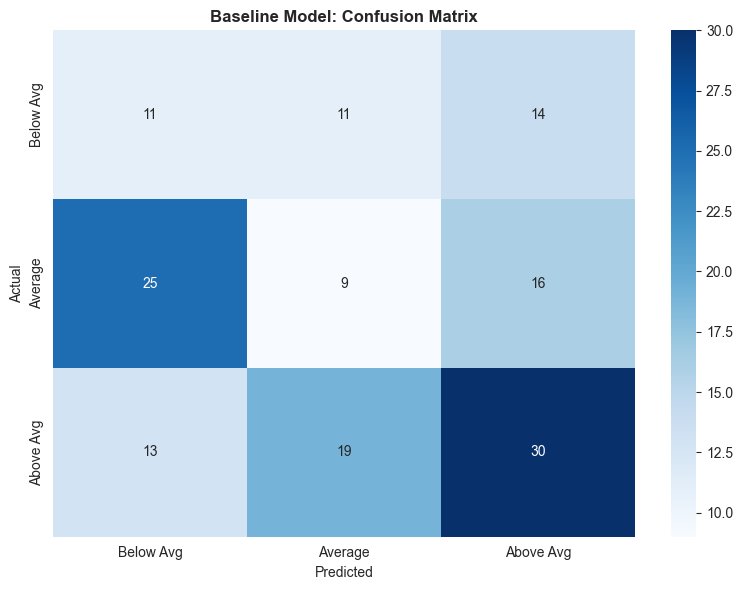


✓ Baseline model trained and evaluated


In [8]:
# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print("="*80)
print("BASELINE MODEL: LOGISTIC REGRESSION")
print("="*80)
print(f"\nClass weights: {class_weight_dict}")

# Train Logistic Regression
lr = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42,
    solver='lbfgs'
)

lr.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr.predict(X_test_scaled)
y_pred_proba_lr = lr.predict_proba(X_test_scaled)

# Evaluation
accuracy_lr = accuracy_score(y_test, y_pred_lr)
f1_macro_lr = f1_score(y_test, y_pred_lr, average='macro')
f1_weighted_lr = f1_score(y_test, y_pred_lr, average='weighted')

print(f"\nBaseline Model Performance:")
print(f"  Accuracy: {accuracy_lr:.4f}")
print(f"  F1 Score (macro): {f1_macro_lr:.4f}")
print(f"  F1 Score (weighted): {f1_weighted_lr:.4f}")

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
print(f"\nConfusion Matrix:")
print(cm_lr)

# Classification Report
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Below Average', 'Average', 'Above Average']))

# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Below Avg', 'Average', 'Above Avg'],
            yticklabels=['Below Avg', 'Average', 'Above Avg'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Baseline Model: Confusion Matrix', fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✓ Baseline model trained and evaluated")

## 9. Production Models (Gradient Boosting)

In [9]:
print("="*80)
print("PRODUCTION MODELS: GRADIENT BOOSTING")
print("="*80)

models = {}
results = []

# 1. LightGBM
print("\n1. Training LightGBM...")
lgb_model = lgb.LGBMClassifier(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.1,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgb_model.fit(X_train, y_train)
models['LightGBM'] = lgb_model

y_pred_lgb = lgb_model.predict(X_test)
y_pred_proba_lgb = lgb_model.predict_proba(X_test)

accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
f1_macro_lgb = f1_score(y_test, y_pred_lgb, average='macro')
f1_weighted_lgb = f1_score(y_test, y_pred_lgb, average='weighted')

results.append({
    'model': 'LightGBM',
    'accuracy': accuracy_lgb,
    'f1_macro': f1_macro_lgb,
    'f1_weighted': f1_weighted_lgb
})

print(f"   Accuracy: {accuracy_lgb:.4f}, F1 (macro): {f1_macro_lgb:.4f}")

# 2. XGBoost
print("\n2. Training XGBoost...")
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.1,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

# Compute sample weights for XGBoost
sample_weights = np.array([class_weight_dict[y] for y in y_train])
xgb_model.fit(X_train, y_train, sample_weight=sample_weights)
models['XGBoost'] = xgb_model

y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f1_macro_xgb = f1_score(y_test, y_pred_xgb, average='macro')
f1_weighted_xgb = f1_score(y_test, y_pred_xgb, average='weighted')

results.append({
    'model': 'XGBoost',
    'accuracy': accuracy_xgb,
    'f1_macro': f1_macro_xgb,
    'f1_weighted': f1_weighted_xgb
})

print(f"   Accuracy: {accuracy_xgb:.4f}, F1 (macro): {f1_macro_xgb:.4f}")

# 3. CatBoost (if available)
if CATBOOST_AVAILABLE:
    print("\n3. Training CatBoost...")
    cb_model = cb.CatBoostClassifier(
        iterations=300,
        depth=7,
        learning_rate=0.1,
        class_weights=class_weight_dict,
        random_state=42,
        verbose=False
    )
    
    cb_model.fit(X_train, y_train)
    models['CatBoost'] = cb_model
    
    y_pred_cb = cb_model.predict(X_test)
    y_pred_proba_cb = cb_model.predict_proba(X_test)
    
    accuracy_cb = accuracy_score(y_test, y_pred_cb)
    f1_macro_cb = f1_score(y_test, y_pred_cb, average='macro')
    f1_weighted_cb = f1_score(y_test, y_pred_cb, average='weighted')
    
    results.append({
        'model': 'CatBoost',
        'accuracy': accuracy_cb,
        'f1_macro': f1_macro_cb,
        'f1_weighted': f1_weighted_cb
    })
    
    print(f"   Accuracy: {accuracy_cb:.4f}, F1 (macro): {f1_macro_cb:.4f}")
else:
    print("\n3. CatBoost skipped (not available)")

# 4. Random Forest (for comparison)
print("\n4. Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
models['Random Forest'] = rf_model

y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_macro_rf = f1_score(y_test, y_pred_rf, average='macro')
f1_weighted_rf = f1_score(y_test, y_pred_rf, average='weighted')

results.append({
    'model': 'Random Forest',
    'accuracy': accuracy_rf,
    'f1_macro': f1_macro_rf,
    'f1_weighted': f1_weighted_rf
})

print(f"   Accuracy: {accuracy_rf:.4f}, F1 (macro): {f1_macro_rf:.4f}")

print("\n✓ All production models trained")

PRODUCTION MODELS: GRADIENT BOOSTING

1. Training LightGBM...
   Accuracy: 0.5000, F1 (macro): 0.4633

2. Training XGBoost...
   Accuracy: 0.4730, F1 (macro): 0.4410

3. Training CatBoost...
   Accuracy: 0.4932, F1 (macro): 0.4647

4. Training Random Forest...
   Accuracy: 0.4730, F1 (macro): 0.4509

✓ All production models trained


MODEL COMPARISON
              model  accuracy  f1_macro  f1_weighted
           CatBoost  0.493243  0.464706     0.483227
           LightGBM  0.500000  0.463337     0.488028
      Random Forest  0.472973  0.450892     0.466864
            XGBoost  0.472973  0.441012     0.463174
Logistic Regression  0.337838  0.317625     0.337310


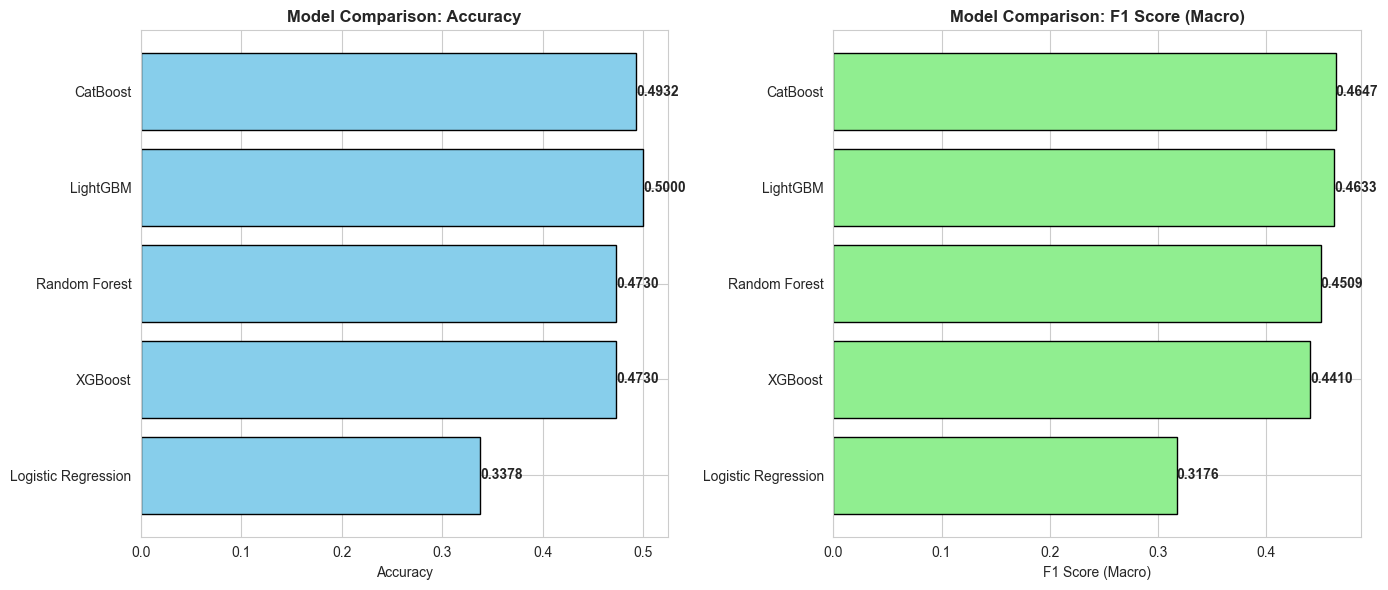


✓ Best model: CatBoost
  Accuracy: 0.4932
  F1 (macro): 0.4647


In [10]:
# Add baseline to results
results.append({
    'model': 'Logistic Regression',
    'accuracy': accuracy_lr,
    'f1_macro': f1_macro_lr,
    'f1_weighted': f1_weighted_lr
})

# Create comparison DataFrame
df_results = pd.DataFrame(results)
df_results = df_results.sort_values('f1_macro', ascending=False)

print("="*80)
print("MODEL COMPARISON")
print("="*80)
print(df_results.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy comparison
axes[0].barh(df_results['model'], df_results['accuracy'], color='skyblue', edgecolor='black')
axes[0].set_xlabel('Accuracy')
axes[0].set_title('Model Comparison: Accuracy', fontweight='bold')
axes[0].invert_yaxis()
for i, v in enumerate(df_results['accuracy']):
    axes[0].text(v, i, f'{v:.4f}', va='center', ha='left', fontweight='bold')

# F1 Macro comparison
axes[1].barh(df_results['model'], df_results['f1_macro'], color='lightgreen', edgecolor='black')
axes[1].set_xlabel('F1 Score (Macro)')
axes[1].set_title('Model Comparison: F1 Score (Macro)', fontweight='bold')
axes[1].invert_yaxis()
for i, v in enumerate(df_results['f1_macro']):
    axes[1].text(v, i, f'{v:.4f}', va='center', ha='left', fontweight='bold')

plt.tight_layout()
plt.show()

# Identify best model
best_model_name = df_results.iloc[0]['model']
best_model = models[best_model_name] if best_model_name in models else lr

print(f"\n✓ Best model: {best_model_name}")
print(f"  Accuracy: {df_results.iloc[0]['accuracy']:.4f}")
print(f"  F1 (macro): {df_results.iloc[0]['f1_macro']:.4f}")

## 11. Detailed Evaluation (Best Model)

DETAILED EVALUATION: CatBoost

Confusion Matrix:
[[15  9 12]
 [14 16 20]
 [10 10 42]]

Classification Report:
               precision    recall  f1-score   support

Below Average       0.38      0.42      0.40        36
      Average       0.46      0.32      0.38        50
Above Average       0.57      0.68      0.62        62

     accuracy                           0.49       148
    macro avg       0.47      0.47      0.46       148
 weighted avg       0.49      0.49      0.48       148


ROC-AUC (One-vs-Rest, macro): 0.6438


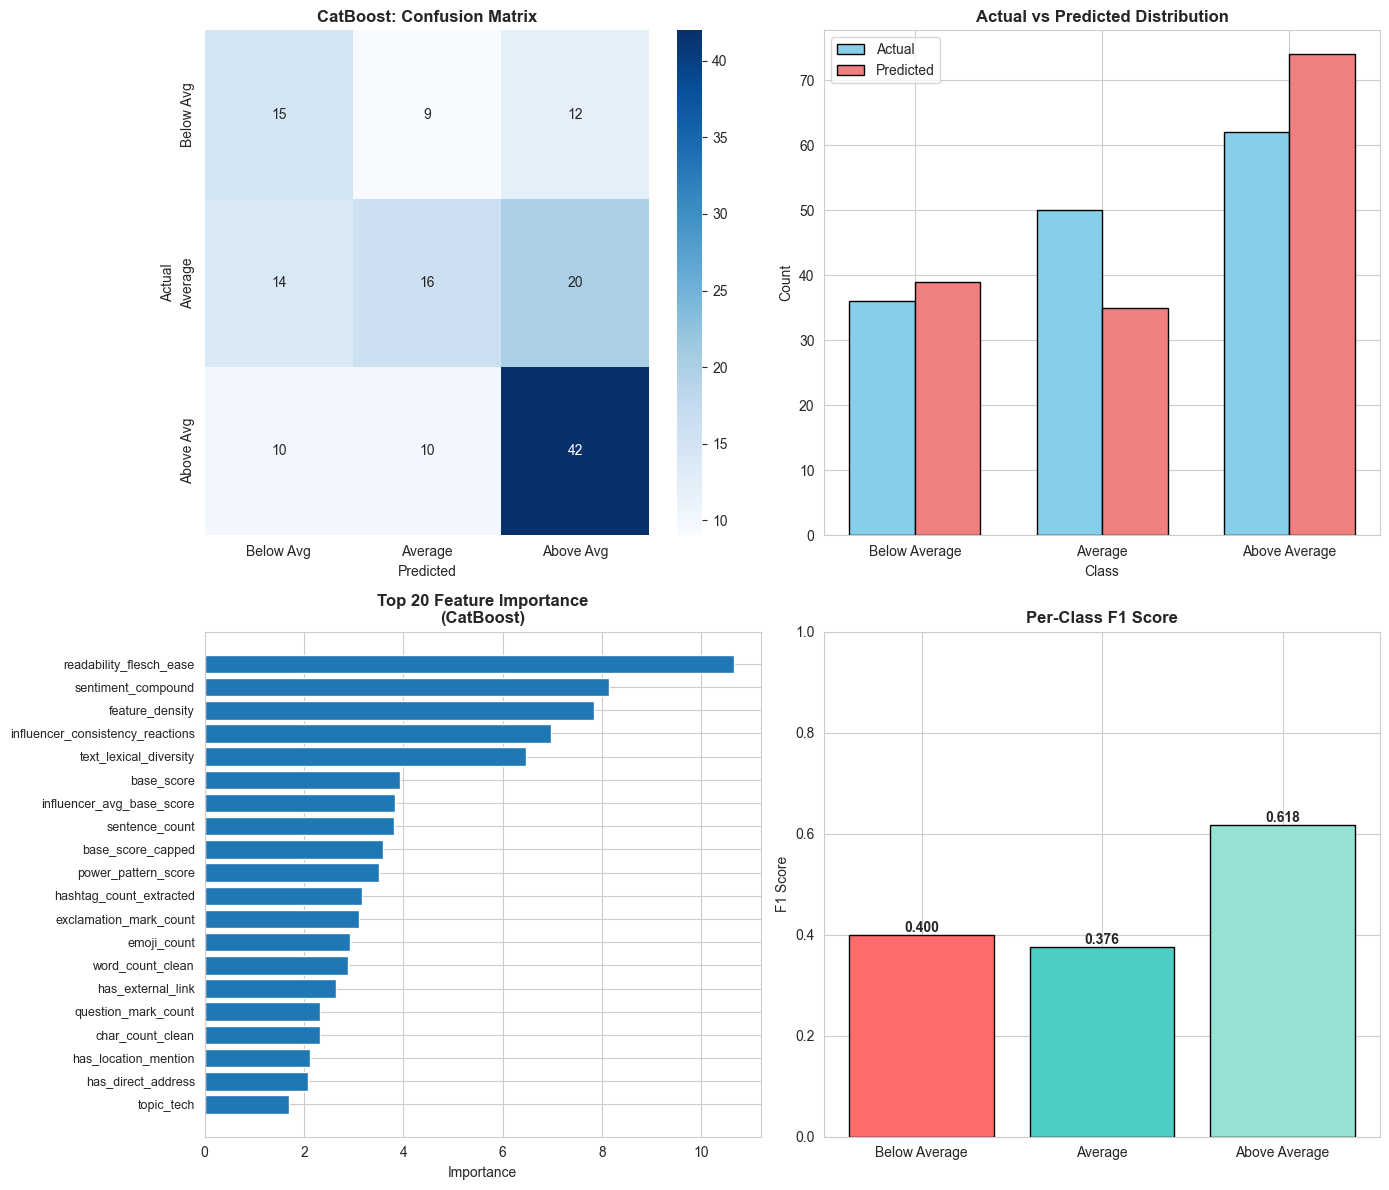


✓ Detailed evaluation complete


In [11]:
# Get predictions from best model
if best_model_name == 'Logistic Regression':
    y_pred_best = y_pred_lr
    y_pred_proba_best = y_pred_proba_lr
elif best_model_name == 'LightGBM':
    y_pred_best = y_pred_lgb
    y_pred_proba_best = y_pred_proba_lgb
elif best_model_name == 'XGBoost':
    y_pred_best = y_pred_xgb
    y_pred_proba_best = y_pred_proba_xgb
elif best_model_name == 'CatBoost':
    y_pred_best = y_pred_cb
    y_pred_proba_best = y_pred_proba_cb
else:
    y_pred_best = y_pred_rf
    y_pred_proba_best = y_pred_proba_rf

# Ensure predictions are 1D (some models return shape (n, 1))
y_pred_best = np.asarray(y_pred_best).ravel()

print("="*80)
print(f"DETAILED EVALUATION: {best_model_name}")
print("="*80)

# Confusion Matrix
cm_best = confusion_matrix(y_test, y_pred_best)
print("\nConfusion Matrix:")
print(cm_best)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, 
                          target_names=['Below Average', 'Average', 'Above Average']))

# ROC-AUC (one-vs-rest for multiclass)
try:
    roc_auc_ovr = roc_auc_score(y_test, y_pred_proba_best, multi_class='ovr', average='macro')
    print(f"\nROC-AUC (One-vs-Rest, macro): {roc_auc_ovr:.4f}")
except Exception as e:
    print(f"\nROC-AUC calculation failed: {e}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Confusion Matrix
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Below Avg', 'Average', 'Above Avg'],
            yticklabels=['Below Avg', 'Average', 'Above Avg'])
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_title(f'{best_model_name}: Confusion Matrix', fontweight='bold')

# Class distribution comparison
class_names = ['Below Average', 'Average', 'Above Average']
actual_counts = pd.Series(y_test).value_counts().sort_index()
predicted_counts = pd.Series(y_pred_best).value_counts().sort_index()

x = np.arange(len(class_names))
width = 0.35
axes[0, 1].bar(x - width/2, actual_counts.values, width, label='Actual', color='skyblue', edgecolor='black')
axes[0, 1].bar(x + width/2, predicted_counts.values, width, label='Predicted', color='lightcoral', edgecolor='black')
axes[0, 1].set_xlabel('Class')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Actual vs Predicted Distribution', fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(class_names)
axes[0, 1].legend()

# Feature Importance (if tree-based model)
if best_model_name in ['LightGBM', 'XGBoost', 'CatBoost', 'Random Forest']:
    if hasattr(best_model, 'feature_importances_'):
        importances = pd.DataFrame({
            'feature': selected_features,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        top20 = importances.head(20).iloc[::-1]
        axes[1, 0].barh(range(len(top20)), top20['importance'])
        axes[1, 0].set_yticks(range(len(top20)))
        axes[1, 0].set_yticklabels(top20['feature'], fontsize=9)
        axes[1, 0].set_xlabel('Importance')
        axes[1, 0].set_title(f'Top 20 Feature Importance\n({best_model_name})', fontweight='bold')

# Per-class performance
per_class_f1 = []
for i in range(3):
    f1 = f1_score(y_test == i, y_pred_best == i)
    per_class_f1.append(f1)

axes[1, 1].bar(class_names, per_class_f1, color=['#ff6b6b', '#4ecdc4', '#95e1d3'], edgecolor='black')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].set_title('Per-Class F1 Score', fontweight='bold')
axes[1, 1].set_ylim([0, 1])
for i, v in enumerate(per_class_f1):
    axes[1, 1].text(i, v, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Detailed evaluation complete")

SHAP INTERPRETATION

Computing SHAP values for CatBoost...
  (Using sample of 100 instances for faster computation)


<Figure size 1000x800 with 0 Axes>

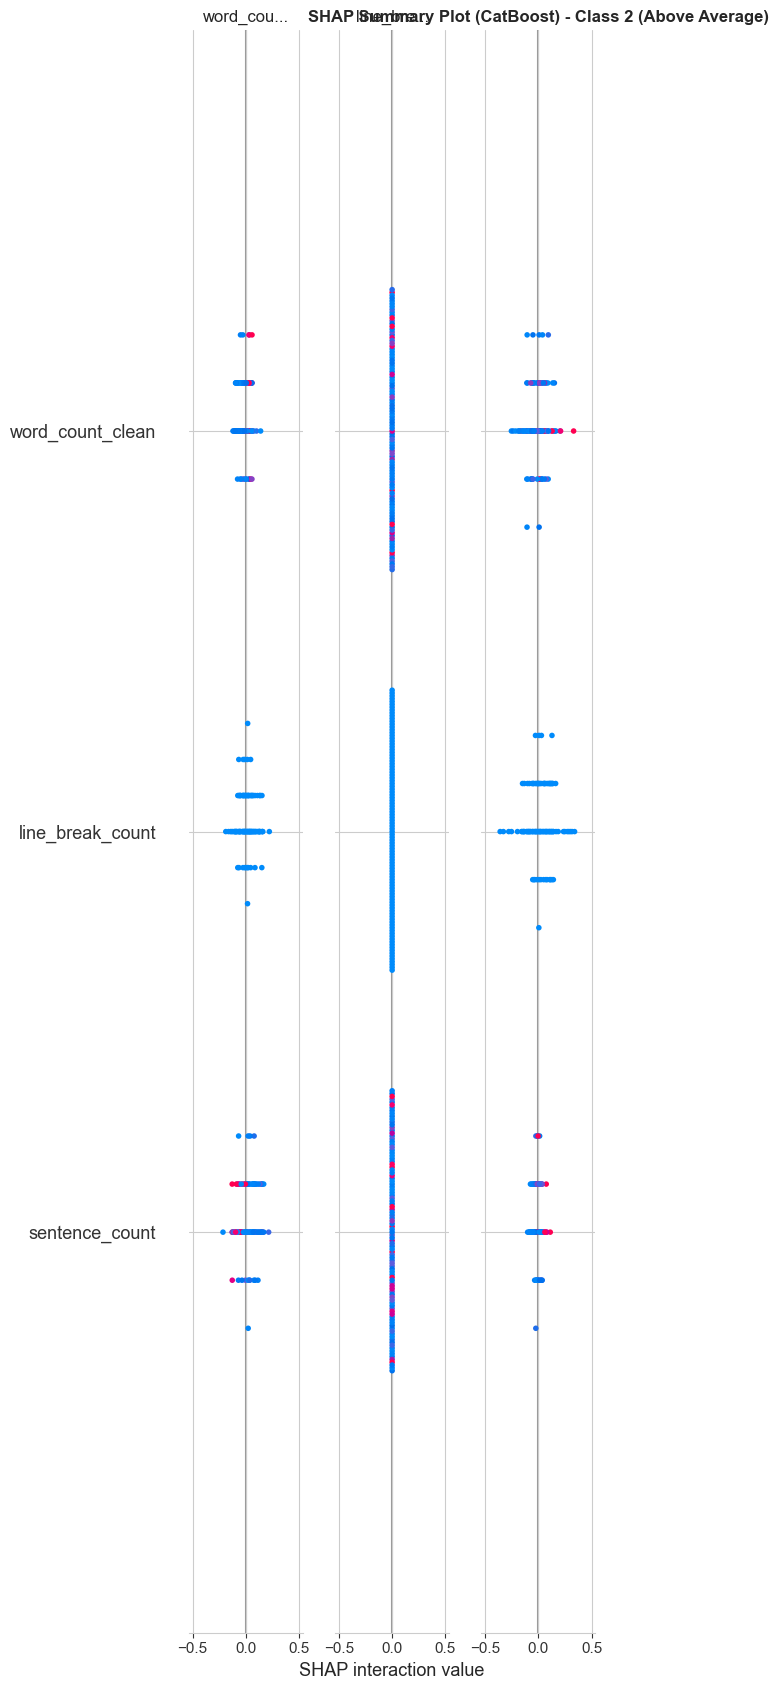


⚠️  SHAP computation failed: Per-column arrays must each be 1-dimensional
  This is okay - feature importance from model is still available


In [12]:
# SHAP values for model interpretation
# Note: SHAP can be slow for large datasets, so we'll use a sample

print("="*80)
print("SHAP INTERPRETATION")
print("="*80)

# Only compute SHAP for tree-based models
if best_model_name in ['LightGBM', 'XGBoost', 'CatBoost', 'Random Forest']:
    print(f"\nComputing SHAP values for {best_model_name}...")
    print("  (Using sample of 100 instances for faster computation)")
    
    # Sample data for SHAP (faster computation)
    sample_size = min(100, len(X_test))
    sample_idx = np.random.choice(len(X_test), sample_size, replace=False)
    X_sample = X_test.iloc[sample_idx] if isinstance(X_test, pd.DataFrame) else X_test[sample_idx]
    
    try:
        # Create SHAP explainer
        if best_model_name == 'LightGBM':
            explainer = shap.TreeExplainer(best_model)
        elif best_model_name == 'XGBoost':
            explainer = shap.TreeExplainer(best_model)
        elif best_model_name == 'CatBoost':
            explainer = shap.TreeExplainer(best_model)
        else:  # Random Forest
            explainer = shap.TreeExplainer(best_model)
        
        shap_values = explainer.shap_values(X_sample)
        
        # For multiclass, shap_values is a list
        if isinstance(shap_values, list):
            # Use class 2 (Above Average) for interpretation
            shap_values_class2 = shap_values[2]
        else:
            shap_values_class2 = shap_values
        
        # Summary plot
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values_class2, X_sample, 
                         feature_names=selected_features, 
                         max_display=20, show=False)
        plt.title(f'SHAP Summary Plot ({best_model_name}) - Class 2 (Above Average)', 
                 fontweight='bold', fontsize=12)
        plt.tight_layout()
        plt.show()
        
        # Feature importance from SHAP
        shap_importance = pd.DataFrame({
            'feature': selected_features,
            'importance': np.abs(shap_values_class2).mean(axis=0)
        }).sort_values('importance', ascending=False)
        
        print("\nTop 15 Features by SHAP Importance:")
        print(shap_importance.head(15).to_string(index=False))
        
        print("\n✓ SHAP interpretation complete")
        
    except Exception as e:
        print(f"\n⚠️  SHAP computation failed: {e}")
        print("  This is okay - feature importance from model is still available")
else:
    print(f"\n⚠️  SHAP not available for {best_model_name}")
    print("  SHAP works best with tree-based models (LightGBM, XGBoost, CatBoost, Random Forest)")

## 13. Cross-Validation (GroupKFold)

CROSS-VALIDATION (GroupKFold by Influencer)

Cross-validating CatBoost...
  Fold 1: Accuracy=0.4452, F1 (macro)=0.4259
  Fold 2: Accuracy=0.4581, F1 (macro)=0.4425
  Fold 3: Accuracy=0.4416, F1 (macro)=0.4153
  Fold 4: Accuracy=0.4351, F1 (macro)=0.4141
  Fold 5: Accuracy=0.4221, F1 (macro)=0.3917

Cross-Validation Results:
  Mean Accuracy: 0.4404 (+/- 0.0237)
  Mean F1 (macro): 0.4179 (+/- 0.0332)


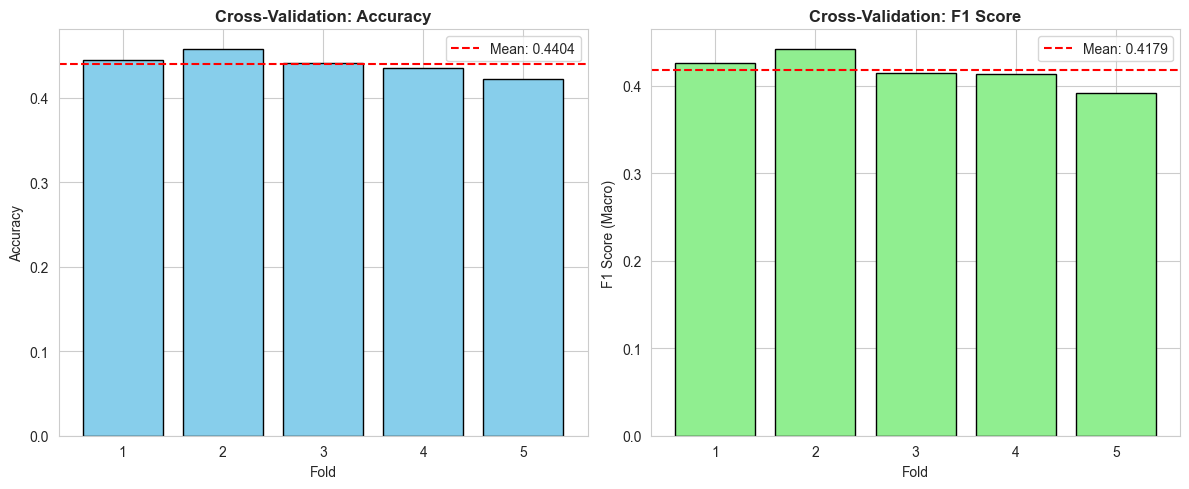


✓ Cross-validation complete


In [13]:
# Cross-validation using GroupKFold to prevent data leakage
print("="*80)
print("CROSS-VALIDATION (GroupKFold by Influencer)")
print("="*80)

# Use full dataset for CV
X_full = X
y_full = y
groups_full = groups

# GroupKFold with 5 folds
gkf = GroupKFold(n_splits=5)

cv_scores = []
cv_f1_scores = []

print(f"\nCross-validating {best_model_name}...")

for fold, (train_idx, val_idx) in enumerate(gkf.split(X_full, y_full, groups_full), 1):
    X_train_cv, X_val_cv = X_full.iloc[train_idx], X_full.iloc[val_idx]
    y_train_cv, y_val_cv = y_full.iloc[train_idx], y_full.iloc[val_idx]
    
    # Train model
    if best_model_name == 'Logistic Regression':
        model_cv = LogisticRegression(
            max_iter=1000,
            class_weight='balanced',
            random_state=42,
            solver='lbfgs'
        )
        scaler_cv = StandardScaler()
        X_train_cv_scaled = scaler_cv.fit_transform(X_train_cv)
        X_val_cv_scaled = scaler_cv.transform(X_val_cv)
        model_cv.fit(X_train_cv_scaled, y_train_cv)
        y_pred_cv = model_cv.predict(X_val_cv_scaled)
    elif best_model_name == 'LightGBM':
        model_cv = lgb.LGBMClassifier(
            n_estimators=300,
            max_depth=7,
            learning_rate=0.1,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1,
            verbose=-1
        )
        model_cv.fit(X_train_cv, y_train_cv)
        y_pred_cv = model_cv.predict(X_val_cv)
    elif best_model_name == 'XGBoost':
        sample_weights_cv = np.array([class_weight_dict[y] for y in y_train_cv])
        model_cv = xgb.XGBClassifier(
            n_estimators=300,
            max_depth=7,
            learning_rate=0.1,
            random_state=42,
            n_jobs=-1,
            eval_metric='mlogloss'
        )
        model_cv.fit(X_train_cv, y_train_cv, sample_weight=sample_weights_cv)
        y_pred_cv = model_cv.predict(X_val_cv)
    elif best_model_name == 'CatBoost' and CATBOOST_AVAILABLE:
        model_cv = cb.CatBoostClassifier(
            iterations=300,
            depth=7,
            learning_rate=0.1,
            class_weights=class_weight_dict,
            random_state=42,
            verbose=False
        )
        model_cv.fit(X_train_cv, y_train_cv)
        y_pred_cv = model_cv.predict(X_val_cv)
    else:  # Random Forest
        model_cv = RandomForestClassifier(
            n_estimators=300,
            max_depth=15,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
        model_cv.fit(X_train_cv, y_train_cv)
        y_pred_cv = model_cv.predict(X_val_cv)
    
    # Evaluate
    accuracy_cv = accuracy_score(y_val_cv, y_pred_cv)
    f1_macro_cv = f1_score(y_val_cv, y_pred_cv, average='macro')
    
    cv_scores.append(accuracy_cv)
    cv_f1_scores.append(f1_macro_cv)
    
    print(f"  Fold {fold}: Accuracy={accuracy_cv:.4f}, F1 (macro)={f1_macro_cv:.4f}")

print(f"\nCross-Validation Results:")
print(f"  Mean Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")
print(f"  Mean F1 (macro): {np.mean(cv_f1_scores):.4f} (+/- {np.std(cv_f1_scores)*2:.4f})")

# Visualize CV results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].bar(range(1, 6), cv_scores, color='skyblue', edgecolor='black')
axes[0].axhline(np.mean(cv_scores), color='red', linestyle='--', label=f'Mean: {np.mean(cv_scores):.4f}')
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Cross-Validation: Accuracy', fontweight='bold')
axes[0].legend()
axes[0].set_xticks(range(1, 6))

axes[1].bar(range(1, 6), cv_f1_scores, color='lightgreen', edgecolor='black')
axes[1].axhline(np.mean(cv_f1_scores), color='red', linestyle='--', label=f'Mean: {np.mean(cv_f1_scores):.4f}')
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('F1 Score (Macro)')
axes[1].set_title('Cross-Validation: F1 Score', fontweight='bold')
axes[1].legend()
axes[1].set_xticks(range(1, 6))

plt.tight_layout()
plt.show()

print("\n✓ Cross-validation complete")

## 14. Save Final Model

In [14]:
# Save model and metadata
import os
from datetime import datetime

MODEL_DIR = '../models_classification/'
os.makedirs(MODEL_DIR, exist_ok=True)

# Save model
if best_model_name == 'Logistic Regression':
    joblib.dump(best_model, f'{MODEL_DIR}classification_model.pkl')
    joblib.dump(scaler, f'{MODEL_DIR}feature_scaler.pkl')
else:
    joblib.dump(best_model, f'{MODEL_DIR}classification_model.pkl')

# Save feature names
with open(f'{MODEL_DIR}feature_names.json', 'w') as f:
    json.dump({
        'features': selected_features,
        'n_features': len(selected_features),
        'model_type': best_model_name
    }, f, indent=2)

# Save metadata
metadata = {
    'version': '1.0',
    'model_type': '3-Class Classification',
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'best_model': best_model_name,
    'dataset': {
        'total_samples': len(df_clean),
        'training_samples': len(X_train),
        'test_samples': len(X_test),
        'n_features': len(selected_features),
        'n_influencers': len(np.unique(groups))
    },
    'target_classes': {
        '0': 'Below Average',
        '1': 'Average',
        '2': 'Above Average'
    },
    'performance': {
        'accuracy': float(df_results.iloc[0]['accuracy']),
        'f1_macro': float(df_results.iloc[0]['f1_macro']),
        'f1_weighted': float(df_results.iloc[0]['f1_weighted']),
        'cv_accuracy_mean': float(np.mean(cv_scores)),
        'cv_accuracy_std': float(np.std(cv_scores)),
        'cv_f1_mean': float(np.mean(cv_f1_scores)),
        'cv_f1_std': float(np.std(cv_f1_scores))
    },
    'class_distribution': {
        'train': y_train.value_counts().to_dict(),
        'test': y_test.value_counts().to_dict()
    }
}

with open(f'{MODEL_DIR}model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("="*80)
print("MODEL SAVED")
print("="*80)
print(f"\nSaved to: {MODEL_DIR}")
print(f"  - classification_model.pkl ({best_model_name})")
if best_model_name == 'Logistic Regression':
    print(f"  - feature_scaler.pkl")
print(f"  - feature_names.json")
print(f"  - model_metadata.json")

print("\n" + "="*80)
print("CLASSIFICATION MODEL TRAINING COMPLETE")
print("="*80)
print(f"\nBest Model: {best_model_name}")
print(f"  Test Accuracy: {df_results.iloc[0]['accuracy']:.4f}")
print(f"  Test F1 (macro): {df_results.iloc[0]['f1_macro']:.4f}")
print(f"  CV Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")
print(f"  CV F1 (macro): {np.mean(cv_f1_scores):.4f} (+/- {np.std(cv_f1_scores)*2:.4f})")
print("\n✓ Model ready for deployment!")

MODEL SAVED

Saved to: ../models_classification/
  - classification_model.pkl (CatBoost)
  - feature_names.json
  - model_metadata.json

CLASSIFICATION MODEL TRAINING COMPLETE

Best Model: CatBoost
  Test Accuracy: 0.4932
  Test F1 (macro): 0.4647
  CV Accuracy: 0.4404 (+/- 0.0237)
  CV F1 (macro): 0.4179 (+/- 0.0332)

✓ Model ready for deployment!
